__Problem statement:__

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma, has the potential to reduce a lot of manual effort needed in diagnosis.

## Step 1: Importing Skin Cancer Data

### 1.1 Importing all libraries & reading data

In [1]:
# Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pathlib
import os
import PIL
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Rescaling, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
# Get the counts of images in train and test data sets
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Number of images in train data set:',image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Number of images in test data set:',image_count_test)

Number of images in train data set: 2239
Number of images in test data set: 118


### 1.2 Load using keras.preprocessing & split the data

Let's load these images off disk using the helpful image_dataset_from_directory utility.

__Create a dataset__

In [5]:
# Define some parameters for the loader:

batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               labels='inferred',
                                                               color_mode='rgb',
                                                               batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               shuffle=True,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             labels='inferred',
                                                             color_mode='rgb',
                                                             batch_size=batch_size,
                                                             image_size=(img_height,img_width),
                                                             shuffle=True,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print("Different types of cancer classes are listed below:\n")
print(class_names)

Different types of cancer classes are listed below:

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### 1.3 Visualize the data

#### Visualize one instance of all the nine classes present in the dataset

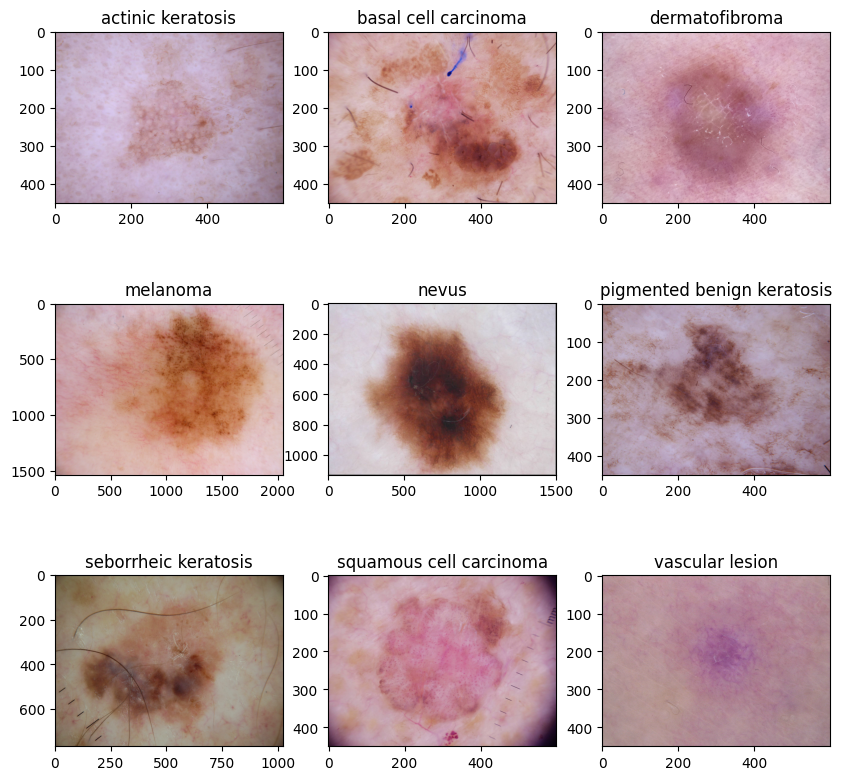

In [9]:
plt.figure(figsize=(10,10))
for i in range(len(class_names)):
    plt.subplot(3,3,i+1)
    sample_image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[i]))
    plt.title(class_names[i])
    plt.imshow(sample_image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape (32,), these are corresponding labels to the `32` images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Step 2: Create the model

Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range.

### 2.1 Model 1

In [11]:
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation
model.add(Conv2D(32,(3,3),activation='relu'))

# Convolution layer with 64 features, 3x3 filter and relu activation
model.add(Conv2D(64,(3,3),activation='relu'))

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(Dropout(0.25))

model.add(Dense(len(class_names),activation='softmax'))

In [12]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 174, 174, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 87, 87, 128)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 968832)            0         
                                                        

In [13]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 304s 2s/step - loss: 7.0882 - accuracy: 0.2176 - val_loss: 1.9419 - val_accuracy: 0.2729
Epoch 2/20
56/56 [==============================] - 11s 192ms/step - loss: 1.9293 - accuracy: 0.2907 - val_loss: 1.9819 - val_accuracy: 0.2662
Epoch 3/20
56/56 [==============================] - 11s 192ms/step - loss: 1.7951 - accuracy: 0.3421 - val_loss: 1.8916 - val_accuracy: 0.3311
Epoch 4/20
56/56 [==============================] - 11s 193ms/step - loss: 1.6840 - accuracy: 0.3951 - val_loss: 1.6884 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 11s 193ms/step - loss: 1.5541 - accuracy: 0.4459 - val_loss: 1.7012 - val_accuracy: 0.4698
Epoch 6/20
56/56 [==============================] - 11s 194ms/step - loss: 1.4301 - accuracy: 0.5011 - val_loss: 1.6874 - val_accuracy: 0.4497
Epoch 7/20
56/56 [==============================] - 11s 192ms/step - loss: 1.7520 - accuracy: 0.3906 - val_loss: 2.0133 - val_accuracy: 0.3020
E

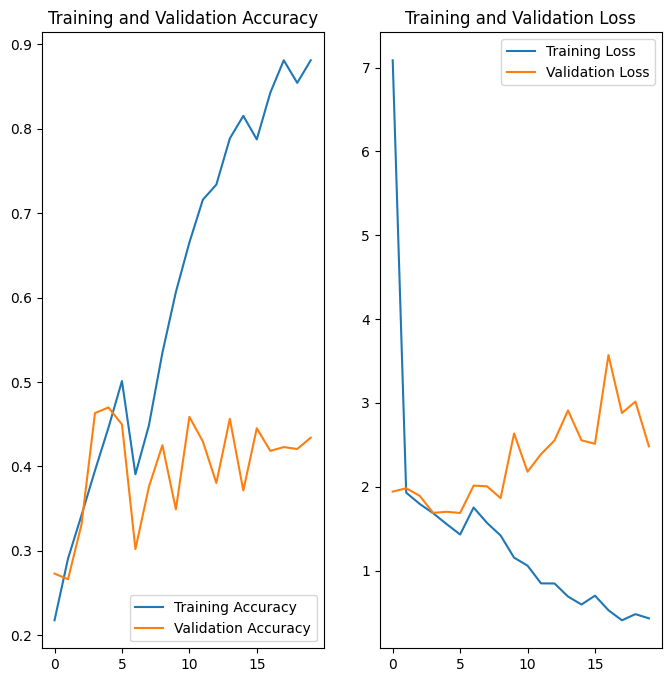

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observations:

As the number of epochs increase, the training accuracy increases whereas the validation accuracy increases to a max value of ~51% and then fluctuates with 1%. As the number of epochs increase, the training loss decreases whereas the validation loss decreases at the starting and later increasing.

Conclusion:

This shows that the model clearly goes over fitting

In [15]:
# evaluate the model on test data
eval_params_val = model.evaluate(val_ds)
eval_params_train = model.evaluate(train_ds)
print('\nModel loss on validation data is:', eval_params_val[0])
print('Model accuracy on validation data is:', eval_params_val[1])

print('\nModel loss on validation data is:', eval_params_train[0])
print('Model accuracy on validation data is:', eval_params_train[1])

56/56 [==============================] - 3s 46ms/step - loss: 0.3670 - accuracy: 0.8906

Model loss on validation data is: 2.4822094440460205
Model accuracy on validation data is: 0.4340044856071472

Model loss on validation data is: 0.3670462965965271
Model accuracy on validation data is: 0.890625


### 2.2 Model 2

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

In [16]:
#Performing data augmentation on the training dataset
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
) 

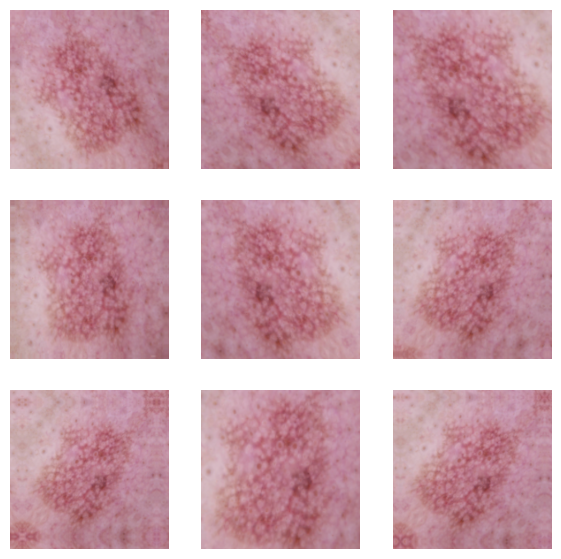

In [18]:
# Visualizing augmentation strategy for one instance of training image.

plt.figure(figsize=(7,7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[1].numpy().astype("uint8"))
        plt.axis("off")

Let's create another model using this augmented data

In [19]:
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 32 features, 3x3 filter and relu activation
model.add(Conv2D(32,(3,3),activation='relu'))

# Convolution layer with 64 features, 3x3 filter and relu activation
model.add(Conv2D(64,(3,3),activation='relu'))

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(Flatten())
model.add(Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(Dropout(0.25))

model.add(Dense(len(class_names),activation='softmax'))  

In [20]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 174, 174, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 87, 87, 128)      0         
 2D)                                                             
                                                      

In [21]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 17s 268ms/step - loss: 4.6018 - accuracy: 0.2701 - val_loss: 1.7134 - val_accuracy: 0.3647
Epoch 2/20
56/56 [==============================] - 15s 261ms/step - loss: 1.7704 - accuracy: 0.3510 - val_loss: 1.5550 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 15s 261ms/step - loss: 1.7517 - accuracy: 0.3711 - val_loss: 1.5719 - val_accuracy: 0.4698
Epoch 4/20
56/56 [==============================] - 15s 262ms/step - loss: 1.6515 - accuracy: 0.4213 - val_loss: 1.6949 - val_accuracy: 0.4385
Epoch 5/20
56/56 [==============================] - 15s 261ms/step - loss: 1.6380 - accuracy: 0.4336 - val_loss: 1.6237 - val_accuracy: 0.4631
Epoch 6/20
56/56 [==============================] - 15s 262ms/step - loss: 1.5507 - accuracy: 0.4643 - val_loss: 1.5859 - val_accuracy: 0.4541
Epoch 7/20
56/56 [==============================] - 15s 262ms/step - loss: 1.6590 - accuracy: 0.4079 - val_loss: 1.7409 - val_accuracy: 0.3602

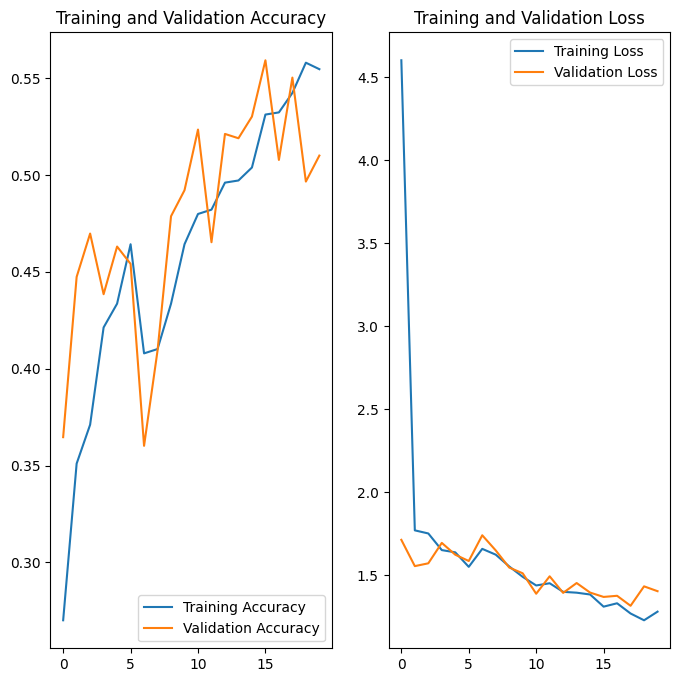

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# evaluate the model on test data
eval_params_val = model.evaluate(val_ds)
eval_params_train = model.evaluate(train_ds)
print('\nModel loss on validation data is:', eval_params_val[0])
print('Model accuracy on validation data is:', eval_params_val[1])

print('\nModel loss on validation data is:', eval_params_train[0])
print('Model accuracy on validation data is:', eval_params_train[1])

56/56 [==============================] - 3s 46ms/step - loss: 1.2196 - accuracy: 0.5698

Model loss on validation data is: 1.4040359258651733
Model accuracy on validation data is: 0.5100671052932739

Model loss on validation data is: 1.219578504562378
Model accuracy on validation data is: 0.5697544813156128


__Observation:__

It can be observed that the training and validation accuracy are almost equal. Also the overfitting of the model is reduced when compared to the initial model but the overall accuracy is not improved.

Let's check the class distribution to see if all the classes(cancer types) are equally distributed

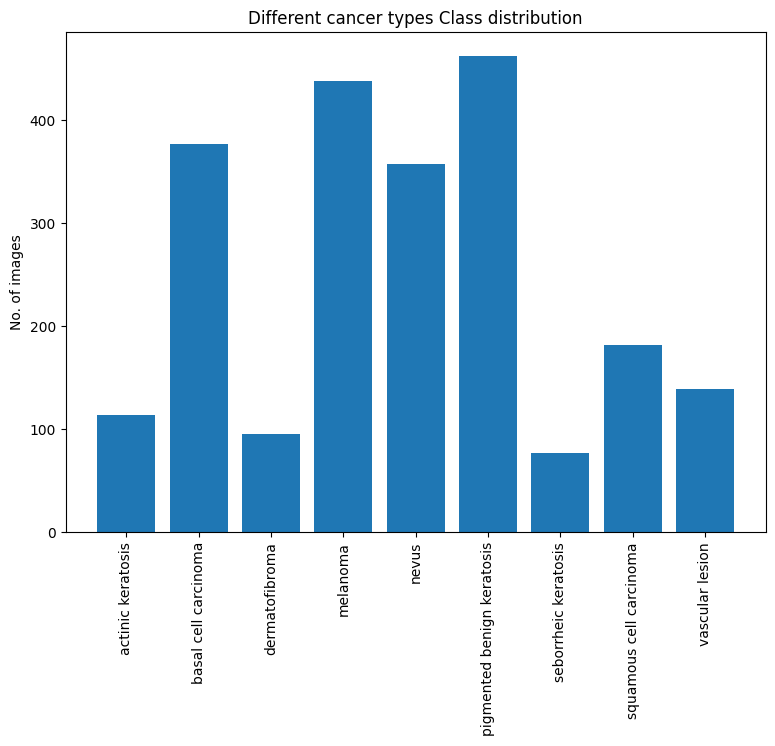

In [24]:
#plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('No. of images')
ax.set_title('Different cancer types Class distribution')
plt.xticks(rotation=90)
plt.show()

In [25]:
print("Number of samples in each class: ")
for i in range(len(class_names)):
  print(class_names[i],' : ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

Number of samples in each class: 
actinic keratosis  :  114
basal cell carcinoma  :  376
dermatofibroma  :  95
melanoma  :  438
nevus  :  357
pigmented benign keratosis  :  462
seborrheic keratosis  :  77
squamous cell carcinoma  :  181
vascular lesion  :  139


__Observation:__

It is observed that the Classs are imbalanced. It can be seen that some classes have higher number of samples compared to the others classes. Class imbalance can have huge effect on the final model quality. 

The class seborrheic keratosis has the least number of samples. 
The class pigmented benign keratosis has the highest number of samples. 

To correct this issue, Augmentor library can be used to artificially generate newer samples.

### 2.3 Model 3

In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
path_to_training_dataset='/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F42E62EBB20>: 100%|██████████| 500/500 [00:25<00:00, 19.39 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F42EAB3BDC0>: 100%|██████████| 500/500 [00:24<00:00, 20.63 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F42EAC4F520>: 100%|██████████| 500/500 [00:19<00:00, 25.51 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F42EAD0AE90>: 100%|██████████| 500/500 [01:41<00:00,  4.95 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F42E63578B0>: 100%|██████████| 500/500 [01:34<00:00,  5.31 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F42EAB5B130>: 100%|██████████| 500/500 [00:21<00:00, 23.67 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F42EAC4ADA0>: 100%|██████████| 500/500 [00:47<00:00, 10.42 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F42EAB59D20>: 100%|██████████| 500/500 [00:19<00:00, 25.24 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F42EAB3BCD0>: 100%|██████████| 500/500 [00:21<00:00, 23.32 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

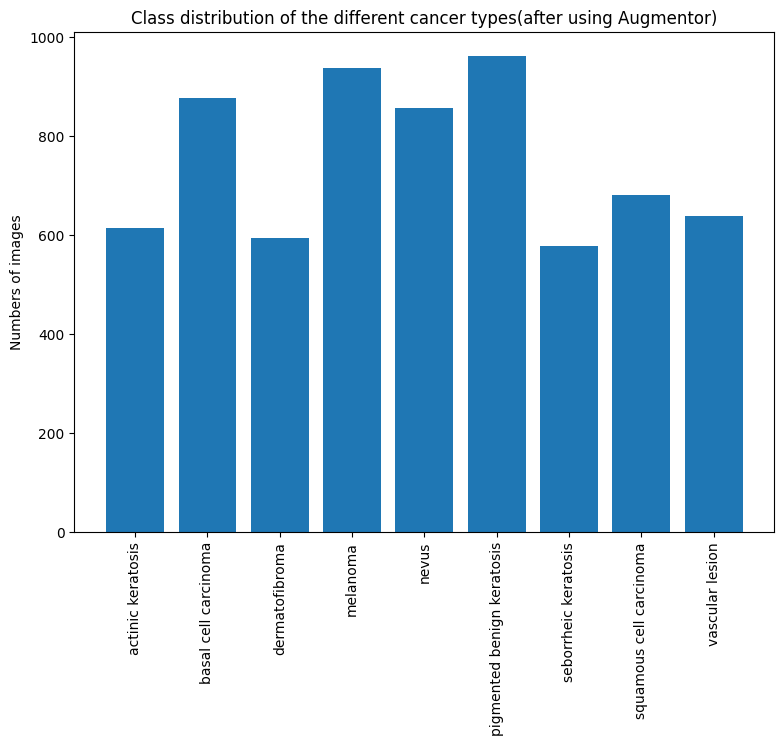

In [29]:
#plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))) + len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types(after using Augmentor)')
plt.xticks(rotation=90)
plt.show()

In [32]:
batch_size = 32
img_height = 180
img_width = 180

In [33]:
data_dir_train='/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [34]:
data_dir_train='/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
val_ds  = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [35]:
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [36]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 128)      

In [37]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 38s 199ms/step - loss: 1.8494 - accuracy: 0.3038 - val_loss: 1.5312 - val_accuracy: 0.4202
Epoch 2/30
169/169 [==============================] - 33s 192ms/step - loss: 1.3996 - accuracy: 0.4761 - val_loss: 1.3399 - val_accuracy: 0.5160
Epoch 3/30
169/169 [==============================] - 38s 220ms/step - loss: 1.2616 - accuracy: 0.5302 - val_loss: 1.1783 - val_accuracy: 0.5650
Epoch 4/30
169/169 [==============================] - 38s 222ms/step - loss: 1.1168 - accuracy: 0.5881 - val_loss: 1.0785 - val_accuracy: 0.6006
Epoch 5/30
169/169 [==============================] - 38s 221ms/step - loss: 0.9927 - accuracy: 0.6307 - val_loss: 0.9983 - val_accuracy: 0.6273
Epoch 6/30
169/169 [==============================] - 34s 194ms/step - loss: 0.8755 - accuracy: 0.6740 - val_loss: 0.9020 - val_accuracy: 0.6823
Epoch 7/30
169/169 [==============================] - 35s 199ms/step - loss: 0.7416 - accuracy: 0.7170 - val_loss: 0.7869 - val_ac

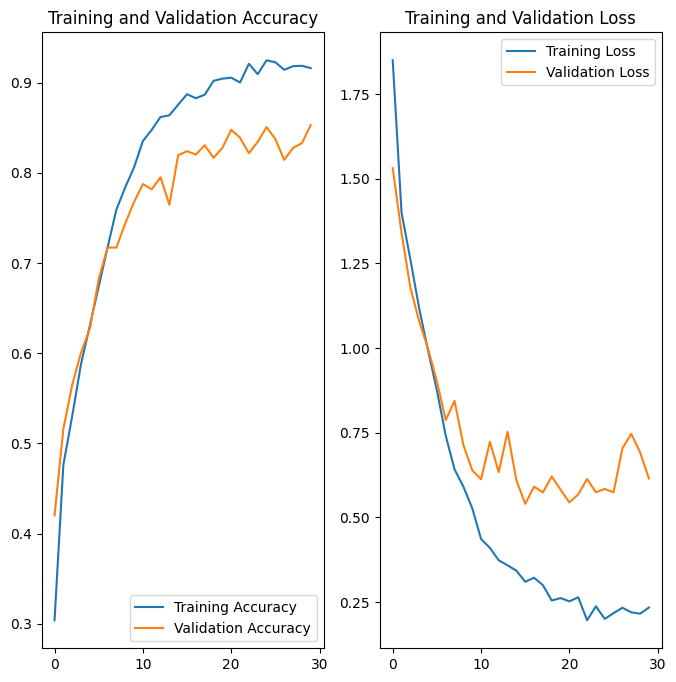

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

__Observation:__ 

With Class rebalance, the training accuracy and validation accuracy both increased. The validation loss also decreases. The training accuracy increased from ~55% to ~91% and validation accuracy also increased from ~56% to ~85%. Finally, Class rebalancing improved the overall accuracy of the model.